In [27]:
import pandas as pd
import numpy as np
import psycopg2
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import datetime


In [28]:
conn = psycopg2.connect(
    host="localhost",
    database="gastos",
    user="postgres",
    password="postgres")

In [29]:
query = '''
select *
from public.gastos_fact g
inner join dia d on d.dia_key = g.dia_key
inner join subcategoria s on s.subcategoria_key = g.subcategoria_key
'''

In [30]:
df = pd.read_sql_query(query,con=conn)

In [31]:
df.describe()

,gastos_fact_key,importe,dia_key,subcategoria_key,saldo,dia,mes,anio,dia_key,subcategoria_key
count,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.00000,847.000000,847.000000
mean,5134.000000,-70.663294,1996.460449,185.207792,442.640661,14.023613,6.962220,2020.36954,1996.460449,185.207792
std,244.652134,103.405459,134.495504,10.492451,469.031485,10.145602,3.449533,0.64075,134.495504,10.492451
min,4711.000000,-1000.000000,1766.000000,165.000000,-339.530000,1.000000,1.000000,2019.00000,1766.000000,165.000000
25%,4922.500000,-80.000000,1876.500000,175.000000,97.685000,4.000000,4.000000,2020.00000,1876.500000,175.000000
50%,5134.000000,-35.170000,1993.000000,191.000000,298.330000,13.000000,7.000000,2020.00000,1993.000000,191.000000
75%,5345.500000,-14.315000,2112.000000,194.000000,651.195000,23.000000,10.000000,2021.00000,2112.000000,194.000000
max,5557.000000,-0.650000,2232.000000,201.000000,2414.940000,31.000000,12.000000,2021.00000,2232.000000,201.000000


In [32]:
df = df.set_index("fecha")

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 847 entries, 2021-09-02 to 2021-11-21
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gastos_fact_key   847 non-null    int64  
 1   importe           847 non-null    float64
 2   dia_key           847 non-null    int64  
 3   subcategoria_key  847 non-null    int64  
 4   saldo             847 non-null    float64
 5   dia               847 non-null    int64  
 6   mes               847 non-null    int64  
 7   anio              847 non-null    int64  
 8   dia_key           847 non-null    int64  
 9   subcategoria_key  847 non-null    int64  
 10  subcategoria      847 non-null    object 
 11  categoria         847 non-null    object 
dtypes: float64(2), int64(8), object(2)
memory usage: 86.0+ KB


# Fechas de analisis

In [44]:
inicio_filtro = datetime.date(2020, 1, 1)
fin_filtro = datetime.date(2021, 11, 30)

filtro = df[(df.index>=inicio_filtro) & (df.index<=fin_filtro) ]

# Suma de gastos por mes y año (con tendencia)

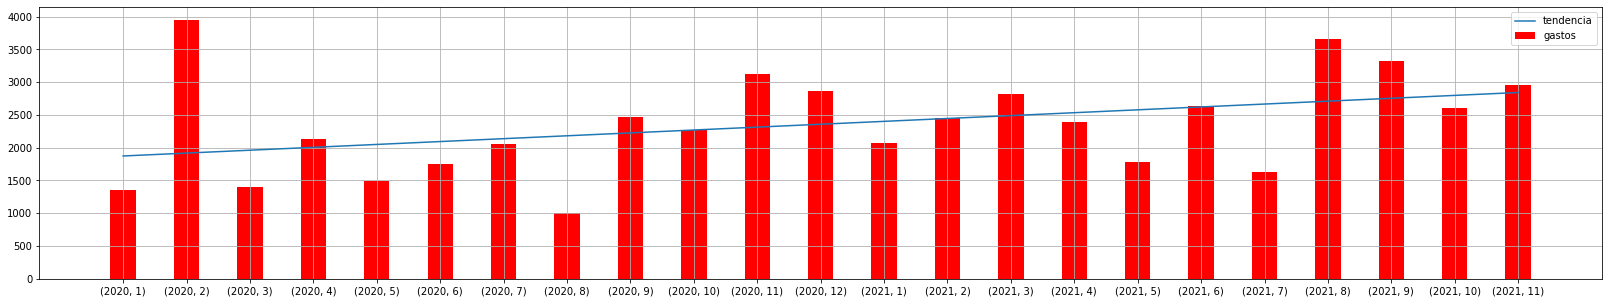

In [45]:
gastos_ac = filtro[filtro.importe<0].groupby(["anio","mes"])["importe"].agg("sum").abs()

#Linear regresion fot trend calculation
X = np.arange(len(gastos_ac.index)).reshape(-1, 1)
y = gastos_ac.to_numpy()

lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

#PLOT
plt.figure(figsize=(28,5))
#plt.bar(x=range(len(ingresos_ac.index)), height=ingresos_ac, label="ingresos", color="g", tick_label=ingresos_ac.index,align="edge", width=-0.4)
plt.bar(x=range(len(gastos_ac.index)), height=gastos_ac.abs(), label="gastos", color="r", tick_label=gastos_ac.index, align="center", width=0.4)
plt.plot(X, y_pred, label = "tendencia")
plt.legend()
plt.grid()


# **Comparativa por años de suma de gastos por mes y año**

<AxesSubplot:xlabel='mes'>

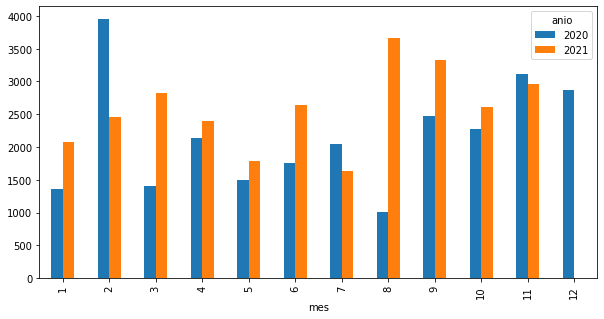

In [46]:
comparativa = filtro[filtro.importe<0].groupby(["mes","anio"])["importe"].agg("sum").abs()
comparativa = comparativa.unstack()
comparativa.plot.bar(figsize=(10,5))

**Media mensual de gastos por año**

In [47]:
filtro.categoria.str.strip().unique()

array(['Movimiento sin categoría', 'Ocio y viajes', 'Otros gastos',
       'Educación, salud y deporte', 'Compras', 'Hogar', 'Alimentación',
       'Vehículo y transporte'], dtype=object)

anio
2020    2157.442500
2021    2577.639091
Name: importe, dtype: float64


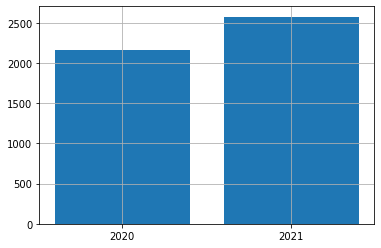

In [48]:
gastos_ac = filtro[(filtro.importe<0)].groupby(["anio","mes"])["importe"].agg("sum").abs()
gastos_ac2 = gastos_ac.groupby(["anio"]).agg("mean")
plt.bar(gastos_ac2.index,gastos_ac2, tick_label=gastos_ac2.index)
plt.grid()
print(gastos_ac2)

**Desglose por mes y categoria**

In [49]:
test = filtro[filtro.importe<0].groupby(["anio","mes","subcategoria"])["importe"].agg("sum").abs()
test2 = test.unstack(fill_value=0)
test2
#test2 = test.groupby(["anio","subcategoria"]).agg("mean").unstack()
test2
#t = test2.unstack()
#t
#t2 = 
#t2
#t.plot.bar(figsize=(10,70), width=0.7,  grid=True, color=["red","blue"], subplots=True)

subcategoria  Actividades extraescolares                                                                                                                                                                                \
anio mes                                                                                                                                                                                                                 
2020 1                                                      0.0                                                                                                                                                          
     2                                                      0.0                                                                                                                                                          
     3                                                      0.0                                                                                                                                                          
     4                                                      0.0                                                                                                                                                          
     5                                                      0.0                                                                                                                                                          
     6                                                      0.0                                                                                                                                                          
     7                                                      0.0                                                                                                                                                          
     8                                                      0.0                                                                                                                                                          
     9                                                      0.0                                                                                                                                                          
     10                                                     0.0                                                                                                                                                          
     11                                                     0.0                                                                                                                                                          
     12                                                     0.0                                                                                                                                                          
2021 1                                                      0.0                                                                                                                                                          
     2                                                      0.0                                                                                                                                                          
     3                                                      0.0                                                                                                                                                          
     4                                                      0.0                                                                                                                                                          
     5                                                     43.5             

# Vamos a intentar quitar atípicos

<AxesSubplot:>

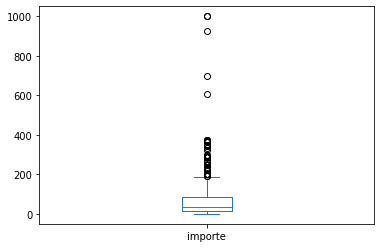

In [50]:
filtro["importe"].abs().plot.box()

vamos a ver los gastos de agosto

In [51]:
filtro[(filtro.mes == 3) & (filtro.anio == 2021)].sort_values(by="importe", ascending=True).head(10)

,gastos_fact_key,importe,dia_key,subcategoria_key,saldo,dia,mes,anio,dia_key,subcategoria_key,subcategoria,categoria
fecha,,,,,,,,,,,,
2021-03-02,4978,-700.00,2012,196,698.39,2,3,2021,2012,196,Transacción entre cuentas de ahorro ...,Movimiento sin categoría ...
2021-03-01,4986,-287.50,2011,175,-333.17,1,3,2021,2011,175,Educación ...,"Educación, salud y deporte ..."
2021-03-01,4987,-287.50,2011,175,-227.03,1,3,2021,2011,175,Educación ...,"Educación, salud y deporte ..."
2021-03-02,4992,-250.00,2012,196,448.39,2,3,2021,2012,196,Transacción entre cuentas de ahorro ...,Movimiento sin categoría ...
2021-03-31,4999,-180.00,2029,197,1317.99,31,3,2021,2029,197,Transferencias ...,Otros gastos ...
2021-03-02,5009,-145.58,2012,187,1398.39,2,3,2021,2012,187,Otros gastos (otros) ...,Otros gastos ...
2021-03-31,5015,-128.75,2029,193,1189.24,31,3,2021,2029,193,Ropa y complementos ...,Compras ...
2021-03-06,5019,-121.76,2015,194,241.63,6,3,2021,2015,194,Supermercados y alimentación ...,Alimentación ...
2021-03-11,5026,-100.00,2017,197,87.15,11,3,2021,2017,197,Transferencias ...,Otros gastos ...
